<div>
<img img class="logo" src="https://medialib.cmcdn.dk/medialibrary/51432DDB-BBE3-4327-85F4-BE3493077470/1D874B35-F493-EC11-84B2-00155D0B0901.png" style="width: 100px;" align="right">
</div>

# <center> Assignment 2 - BuyWise Analytics

### <center> KAN-CDSCV1008U  Applied Machine Learning and Data Engineering in Business Context

In [14]:
# Importing modules 
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [15]:
# Importing datasets 
features = pd.read_csv("C:/Users/fredr/OneDrive/Documents/Master/Semester_3/Applied ML/AppliedML_Assign.01/Assignment2/Data/Features data set.csv")
sales = pd.read_csv("C:/Users/fredr/OneDrive/Documents/Master/Semester_3/Applied ML/AppliedML_Assign.01/Assignment2/Data/sales data-set.csv")
stores = pd.read_csv("C:/Users/fredr/OneDrive/Documents/Master/Semester_3/Applied ML/AppliedML_Assign.01/Assignment2/Data/stores data-set.csv")

In [16]:
# Convert the date column to datetime format 
features["Date"] = pd.to_datetime(features["Date"], format="%d/%m/%Y")
sales["Date"] = pd.to_datetime(sales["Date"], format="%d/%m/%Y")

In [17]:
# Dropping unnecessary columns
sales.drop(columns=['Dept'], inplace=True)

In [18]:
# Forwoard fill impution for 'CPI' and 'Unemployment'
features['CPI'].fillna(method='ffill', inplace=True)
features['Unemployment'].fillna(method='ffill', inplace=True)

In [19]:
features['Week'] = features.Date.dt.week

C:\Users\fredr\AppData\Local\Temp\ipykernel_15848\2978714185.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  features['Week'] = features.Date.dt.week


In [20]:
# Imputing Markdown columns
# Impute NaN values based on weekly average
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_columns:
    weekly_avg = features.groupby('Week')[col].transform('mean')
    features[col].fillna(weekly_avg, inplace=True)

# can't impute all values for MarkDown2 , dropping Markdown2.

features.drop('MarkDown2', axis = 1, inplace=True)
features.drop('Week', axis=1, inplace=True)
features.head()


      Store       Date  Temperature  Fuel_Price     MarkDown1    MarkDown2  \
0         1 2010-02-05        42.31       2.572  24089.612333  1943.950444   
1         1 2010-02-12        38.51       2.548  29880.900556  2524.795909   
2         1 2010-02-19        39.93       2.514  12536.748111  5631.042778   
3         1 2010-02-26        46.63       2.561   8504.312444  4519.585444   
4         1 2010-03-05        46.50       2.625  11293.039000  1050.266627   
...     ...        ...          ...         ...           ...          ...   
8185     45 2013-06-28        76.05       3.639   4842.290000   975.030000   
8186     45 2013-07-05        77.50       3.614   9090.480000  2268.580000   
8187     45 2013-07-12        79.37       3.614   3789.940000  1827.310000   
8188     45 2013-07-19        82.84       3.737   2961.490000  1047.070000   
8189     45 2013-07-26        76.06       3.804    212.020000   851.730000   

       MarkDown3     MarkDown4    MarkDown5         CPI  Unempl

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,24089.612333,198.031818,24865.942619,4185.380333,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,29880.900556,197.092500,20305.431829,5089.147556,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,12536.748111,59.385610,7038.310625,5646.276000,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,8504.312444,25.995714,2879.735679,4458.685000,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,11293.039000,22.353662,6312.144304,2911.005778,211.350143,8.106,False


In [22]:
# Encoding 'IsHoliday' & 'Type'
label_encoder = LabelEncoder()
features['IsHoliday'] = label_encoder.fit_transform(features['IsHoliday'])
sales['IsHoliday'] = label_encoder.fit_transform(sales['IsHoliday'])
stores['Type'] = label_encoder.fit_transform(stores['Type'])

In [23]:
# Merging the data
tmp_df = pd.merge(sales, features, on=['Store', 'Date', 'IsHoliday'], how='left')
df = pd.merge(stores, tmp_df, on=['Store'], how='left')
df.head()

,Store,Type,Size,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,0,151315,2010-02-05,24924.50,0,42.31,2.572,24089.612333,198.031818,24865.942619,4185.380333,211.096358,8.106
1,1,0,151315,2010-02-12,46039.49,1,38.51,2.548,29880.900556,197.092500,20305.431829,5089.147556,211.242170,8.106
2,1,0,151315,2010-02-19,41595.55,0,39.93,2.514,12536.748111,59.385610,7038.310625,5646.276000,211.289143,8.106
3,1,0,151315,2010-02-26,19403.54,0,46.63,2.561,8504.312444,25.995714,2879.735679,4458.685000,211.319643,8.106
4,1,0,151315,2010-03-05,21827.90,0,46.50,2.625,11293.039000,22.353662,6312.144304,2911.005778,211.350143,8.106


In [27]:
df_date = df.groupby('Date').agg({'Temperature': 'mean',
                                       'Fuel_Price': 'mean',
                                       'CPI': 'mean',
                                       'Unemployment': 'mean', 
                                       'Weekly_Sales': 'mean',
                                       'IsHoliday': 'min',
                                       'MarkDown1': 'mean',
                                       'MarkDown3': 'mean',
                                       'MarkDown4': 'mean',
                                       'MarkDown5': 'mean'}).reset_index()
df_date.head()

,Date,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales,IsHoliday,MarkDown1,MarkDown3,MarkDown4,MarkDown5
0,2010-02-05,33.277942,2.717869,167.398405,8.576731,16836.121997,0,24089.612333,198.031818,24865.942619,4185.380333
1,2010-02-12,33.361810,2.696102,167.384138,8.567309,16352.056032,1,29880.900556,197.092500,20305.431829,5089.147556
2,2010-02-19,37.038310,2.673666,167.338966,8.576351,16216.658979,0,12536.748111,59.385610,7038.310625,5646.276000
3,2010-02-26,38.629563,2.685642,167.691019,8.561375,14899.549688,0,8504.312444,25.995714,2879.735679,4458.685000
4,2010-03-05,42.373998,2.731816,167.727351,8.572689,15921.015727,0,11293.039000,22.353662,6312.144304,2911.005778


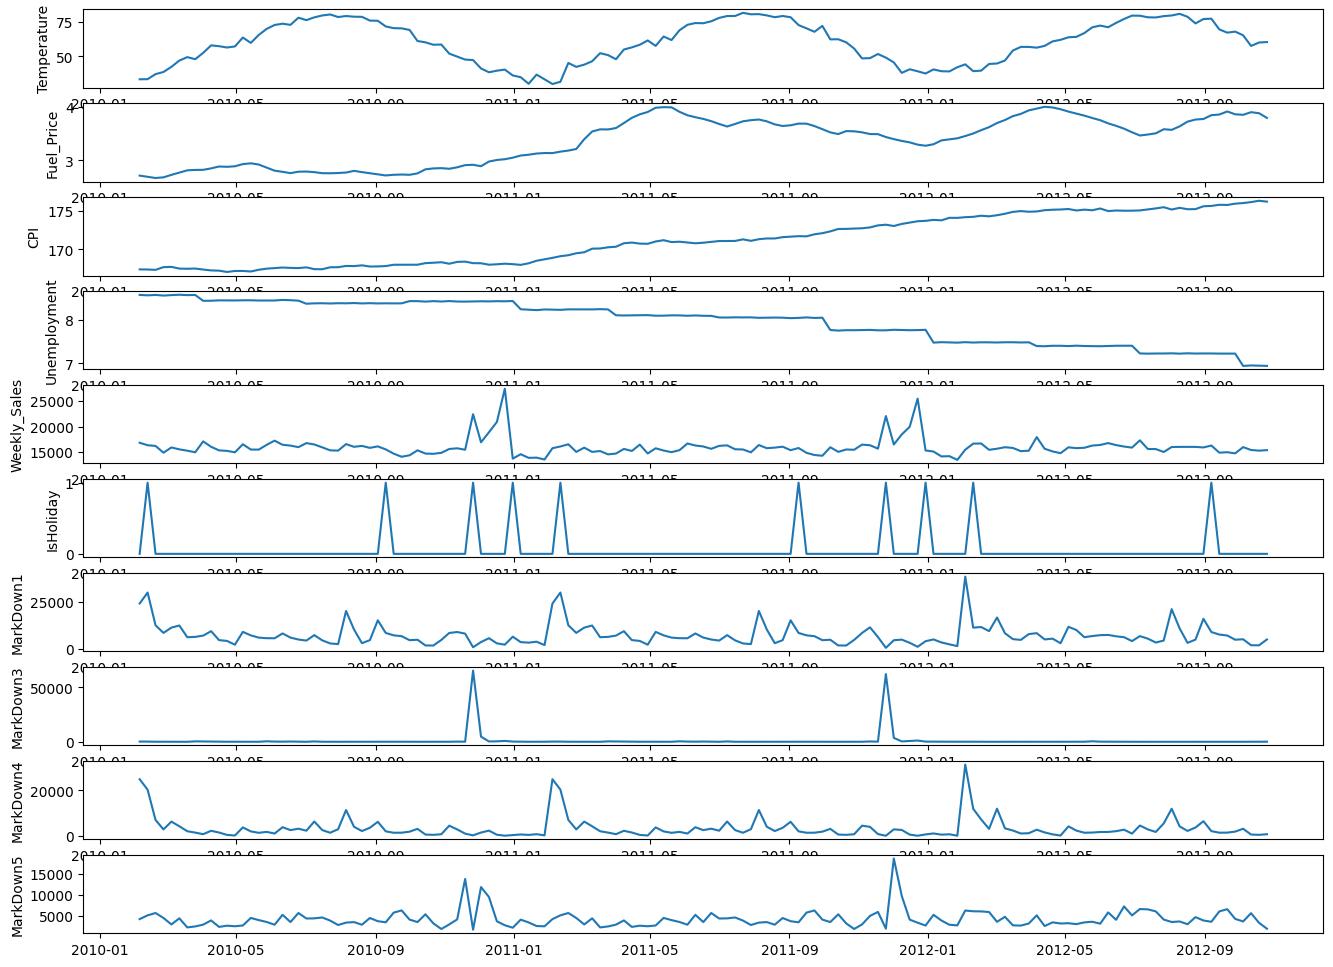

In [28]:
# Plotting all features
fig = plt.figure(figsize = (16, 12))
count_columns_ex_date = len(df_date.columns[1:])
for idx, col in enumerate(df_date.columns[1:]):
    plt.subplot(count_columns_ex_date, 1, idx+1)
    plt.plot(df_date["Date"], df_date[col])
    plt.ylabel(col)